## Only using tensorflow to import a dataset

In [137]:
import numpy as np
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

<ipython-input-138-de66bb0fd666>:2: DeprecationWarning: This function is deprecated. Please call randint(0, 60000 + 1) instead
  start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]


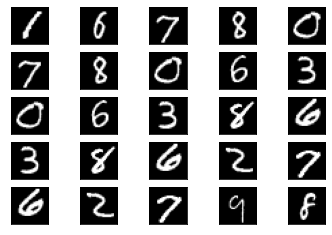

In [138]:
side = 5
start = np.random.random_integers(low=0, high=x_train.shape[0], size=(1,))[0]
fig, ax = plt.subplots(side, side)
for a in range(side):
    for b in range(side):
        ax[a, b].axes.xaxis.set_visible(False)
        ax[a, b].axes.yaxis.set_visible(False)
        ax[a, b].imshow(x_train[2 * a + b + start, :, :], cmap='gray')
plt.show()

## Code

## Import

In [139]:
import numpy as np

## flatten and reshape

In [140]:
print("x_train:", x_train.shape)
x_train = x_train.reshape(x_train.shape[0], -1).T # flatten
print("x_train flatten:", x_train.shape)

print("x_test:", x_test.shape)
x_test = x_test.reshape(x_test.shape[0], -1).T # flatten
print("x_test flatten:", x_test.shape)

print("y_train:", y_train.shape)
y_train = y_train.reshape(y_train.shape[0],1).T # reshape
print("y_train:", y_train.shape)

print("y_test:", y_test.shape)
y_test = y_test.reshape(y_test.shape[0],1).T # reshape
print("y_test:", y_test.shape)

x_train: (60000, 28, 28)
x_train flatten: (784, 60000)
x_test: (10000, 28, 28)
x_test flatten: (784, 10000)
y_train: (60000,)
y_train: (1, 60000)
y_test: (10000,)
y_test: (1, 10000)


## One Hot

In [141]:
y_train_onehot = np.zeros((len(np.unique(y_train)), y_train.shape[1]))
y_test_onehot = np.zeros((len(np.unique(y_test)), y_test.shape[1]))

for i in range(y_train.shape[1]):
    y_train_onehot[y_train[0][i]][i] = 1
for i in range(y_test.shape[1]):
    y_test_onehot[y_test[0][i]][i] = 1

print(y_train)

print(y_train_onehot.shape)
for i in y_train_onehot:
    print(i)

[[5 0 4 ... 5 6 8]]
(10, 60000)
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 0. 1. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 1.]
[0. 0. 0. ... 0. 0. 0.]


## Normalization

In [142]:
x_train = x_train/255
x_test = x_test/255

## initialize_parameters

In [143]:
def initialize_parameters(layers_dims):
    parameters = {}
    L = len(layers_dims) - 1
        
    for l in range(1, L+1):
        parameters['W'+str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2./layers_dims[l-1])
        parameters['b'+str(l)] = np.ones((layers_dims[l], 1), dtype=np.float32)
    
    return parameters

## activation_funtion

In [144]:
def activation_funtion(Z, activation):
    if activation == "relu":
        return np.maximum(np.zeros(1), Z)
        
    if activation == "sigmoid":
        return 1 / (1 + np.exp(-Z))
    
    return Z

## forward_propagation

In [145]:
def forward_propagation(X, parameters, activation):
    cache = {}
    L = len(parameters) // 2
    cache['A0'] = X
    
    for l in range(1,L):
        cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
        cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])

    l += 1
    
    cache['Z'+str(l)] = np.dot(parameters['W'+str(l)], cache['A'+str(l-1)]) + parameters['b'+str(l)]
    cache['A'+str(l)] = activation_funtion(cache['Z'+str(l)], activation[l-1])
    
    return cache

## compute_cost

In [146]:
def compute_cost(AL,Y, loss = "cross_entropy"):
    m = Y.shape[1]
    
    AL = AL.T
    if loss == "cross_entropy":
        epsilon = 1e-7
        cost = -(1/m) * np.sum(np.multiply(np.log(AL + epsilon), Y) + np.multiply(np.log(1-AL + epsilon), 1-Y))
        return np.squeeze(cost)


In [147]:
def activation_derivative(Z, activation):
    if activation == "relu":
        dZ = np.ones(Z.shape)
        return (dZ >= 0).astype(int)
        
    if activation == "sigmoid":
        return np.multiply(activation_funtion(Z, "sigmoid"), (1- activation_funtion(Z, "sigmoid")))
    
    return Z

## back_propagation

In [148]:
def back_propagation(X, Y, parameters, cache, activation):
    grads = {}
    L = len(parameters) // 2
    m = Y.shape[1]
    
    grads["dZ" + str(L)] = cache['A' + str(L)] - Y
    grads["dW" + str(L)] = (1/m) * np.dot(grads["dZ" + str(L)], cache['A' + str(L-1)].T)
    grads["db" + str(L)] = (1/m) * np.sum(grads["dZ" + str(L)], axis= 1, keepdims= True)
    
    for l in range(L-1,1,-1):
        grads["dZ" + str(l)] = np.multiply(np.dot(parameters["W" + str(l+1)].T, grads["dZ" + str(l+1)]), activation_derivative(cache["Z" + str(l)],activation[l-1]))        
        grads["dW" + str(l)] = (1/m) * np.dot(grads["dZ" + str(l)], cache['A' + str(l-1)].T)
        grads["db" + str(l)] = (1/m) * np.sum(grads["dZ" + str(l)], axis= 1, keepdims= True)
    l -= 1
    
    grads["dZ" + str(l)] = np.multiply(np.dot(parameters["W" + str(l+1)].T, grads["dZ" + str(l+1)]), activation_derivative(cache["Z" + str(l)],activation[l-1]))
    grads["dW" + str(l)] = (1/m) * np.dot(grads["dZ" + str(l)], cache['A' + str(l-1)].T)
    grads["db" + str(l)] = (1/m) * np.sum(grads["dZ" + str(l)], axis= 1, keepdims= True)
    
    return grads

## update_parameters

In [149]:
def update_parameters(grads, paramaters, lr=0.01):
    
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - np.multiply(grads['dW'+str(l)], lr)
        parameters['b'+str(l)] = parameters['b'+str(l)] - np.multiply(grads['db'+str(l)], lr)
    
    return parameters

## prediction

In [150]:
def prediction(X, Y, parameters, activation):
    cache = forward_propagation(X, parameters, activation)
    
    cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, Y)
    
    pred = cache['A' + str(len(parameters) // 2)] - Y
    
    print(pred)
    
    return "train cost: " + str(cost)

In [157]:
layers_dims = [x_train.shape[0],128,128,10]
activation = ["relu","relu","sigmoid"]
# loss_funtion = "cross_entropy"

print(x_train.shape)
print(y_train.shape)

parameters = initialize_parameters(layers_dims)

iter = 1000

for i in range(iter):
    cache = forward_propagation(x_train, parameters, activation)

    
    if i % 10 == 0:
        cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, y_train_onehot)
        print("cost train: " + str(cost), end= " ")
        cache_test = forward_propagation(x_test, parameters, activation)
        cost = compute_cost(cache_test['A' + str(len(parameters) // 2)].T, y_test_onehot)
        print("cost test: " + str(cost))
        
    grads = back_propagation(x_train, y_train_onehot, parameters, cache, activation)

    parameters = update_parameters(grads, parameters, 0.001)

print(parameters)


(784, 60000)
(1, 60000)
cost train: 11.938267920362371 cost test: 11.936987380681677
cost train: 5.206022943424012 cost test: 5.193811559302215
cost train: 3.7839086806478135 cost test: 3.7837118436041943
cost train: 3.4121855088485957 cost test: 3.4166302985966293
cost train: 3.2708529089360243 cost test: 3.2771634685279505
cost train: 3.199514826347446 cost test: 3.206590430100913
cost train: 3.1539124852551437 cost test: 3.161213839081068
cost train: 3.1190422368023163 cost test: 3.1262317651830323
cost train: 3.089136270262567 cost test: 3.0960212532887836
cost train: 3.0617729818760804 cost test: 3.068227765471236
{'W1': array([[-0.00288467, -0.07737397, -0.03656331, ...,  0.00951725,
        -0.02478701, -0.00243739],
       [-0.07250234,  0.14898522,  0.0668685 , ...,  0.09078368,
         0.10656975, -0.06789254],
       [-0.04401647,  0.00925436, -0.09887636, ..., -0.05645279,
        -0.05735528, -0.02357567],
       ...,
       [ 0.03408777, -0.02730129,  0.04506789, ...,  0

In [158]:
print(parameters['W1'].shape)

(64, 784)


In [152]:
for i in y_train:
    print(i)

for i in y_train_onehot:
    print(i)
    
for i in cache['A' + str(len(parameters) // 2)]:
    print(i)

[5 0 4 ... 5 6 8]
[0. 1. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 1. ... 0. 0. 0.]
[1. 0. 0. ... 1. 0. 0.]
[0. 0. 0. ... 0. 1. 0.]
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 1.]
[0. 0. 0. ... 0. 0. 0.]
[0.08633238 0.18033136 0.12162387 ... 0.04907181 0.12469276 0.07906813]
[0.12877244 0.06705173 0.31983324 ... 0.06795332 0.0792704  0.05981276]
[0.12035397 0.04224343 0.03734403 ... 0.01647465 0.0623367  0.07264538]
[0.0552662  0.11625205 0.13011353 ... 0.15128968 0.10704427 0.20781647]
[0.10277291 0.16306274 0.05782511 ... 0.08260195 0.15778471 0.19389569]
[0.09207335 0.02531124 0.07762592 ... 0.14006003 0.08903517 0.03398981]
[0.10577976 0.21267035 0.09195765 ... 0.06966628 0.24699272 0.11444749]
[0.14820907 0.11083755 0.1154105  ... 0.10002489 0.14268301 0.10666897]
[0.12979276 0.14468827 0.09495351 ... 0.1699223  0.18383774 0.19837276]
[0.08616729 0.07299232 0.13445581 ... 0.02306324 0.13151627 0.13073029]


In [153]:
layers_dims = [32,18,7,2] # 3NN
activation = ["relu","relu","sigmoid"] # 3 Activation to 3NN
# loss_funtion = "cross_entropy"

X = np.random.randn(layers_dims[0],15) * 10
Y = np.array([[0, 1, 0.2, 0.5, 0.2, 0, 1, 0.2, 0.5, 0.2, 0, 1, 0.2, 0.5, 0.2]])

parameters = initialize_parameters(layers_dims)

iter = 1500

for i in range(iter):
    cache = forward_propagation(X, parameters, activation)

    cost = compute_cost(cache['A' + str(len(parameters) // 2)].T, Y)
    if i % 10 == 0:
        print(cost)
    grads = back_propagation(X, Y, parameters, cache, activation)

    parameters = update_parameters(grads, parameters, 0.02)

print(parameters)


10.935172008994574
1.1671661835510825
1.0248640780624645
0.9045712117327168
0.819435371501045
0.7806924163908177
0.9645649202726483
0.752139365831062
0.8063711494096812
0.7409384196101078
0.7999494549506994
0.7337971863369522
0.7964205459422647
0.8606025560842641
0.7852545857153048
0.7576567361178419
0.7676040552438472
0.7172258195295066
0.7765295490919086
0.7104992309928523
0.7455353222329454
0.7775664588785248
0.8779435248043931
0.8369774161929218
0.6891157864838767
0.7513126960857918
0.7642192117492723
0.8381324320518364
0.8596342906770266
0.7428485753039648
0.8074165802418182
0.7599354055767613
0.7767855874676158
0.7316359745049056
0.7524409228630288
0.7245945092375616
0.7272645046145967
0.722192371052994
0.7192920824182033
0.7166323413528554
0.7142451477595153
0.7120942330575977
0.7101652434287812
0.7051373129690984
0.7007949403482653
0.6978778720159905
0.6954788788002574
0.6947325057615992
0.6944772085882136
0.6942430719244247
0.6940280771045733
0.6938267705032721
0.6936352486062